# Run ML trajectories

We want to run a trajectory with the mace potential and see if the uncertainty spikes when we go off course

In [1]:
import numpy as np
from scipy.stats import pearsonr
from pathlib import Path
import os
from glob import glob
from collections import defaultdict

%matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
from ase.io import read
from ase import units
from ase.md.npt import NPT
from tqdm.auto import tqdm

from mace.calculators.foundations_models import mace_mp
from mace.calculators import MACECalculator

/home/mike/miniconda3/envs/cascade/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Configuration

In [2]:
!ls ../0_setup/md/packmol-CH4-in-H2O=32-seed=3-blyp-npt=298/

md.log	md.traj


In [3]:
infer_device: str = 'cuda:0'
temperature = 298
steps: int = 512
initial_geometry = '../0_setup/final-geometries/packmol-CH4-in-H2O=32-seed=3-blyp.vasp'
reference_trajectory = '../0_setup/md/packmol-CH4-in-H2O=32-seed=3-blyp-npt=298/md.traj'

In [4]:
_initial_geometry = read(initial_geometry)
_reference_trajectory = read(reference_trajectory, index=':')

In [5]:
np.isclose(
    _reference_trajectory[0].get_positions(),
    _initial_geometry.positions
).mean()

0.0033003300330033004

### get ensemble members from directory

In [6]:
model_files = os.listdir('ensemble/')
model_files = [Path('ensemble')/f for f in model_files]

MACECalculator can take multiple models in a list

In [7]:
model_files

[PosixPath('ensemble/model_2.pt'),
 PosixPath('ensemble/model_3.pt'),
 PosixPath('ensemble/model_0.pt'),
 PosixPath('ensemble/model_1.pt')]

In [8]:
calculators = {
    'mace_small_pretrained': mace_mp('small', device=infer_device),
    'mace_small_finetuned': MACECalculator(model_paths=model_files, device=infer_device)
}

Using Materials Project MACE for MACECalculator with /home/mike/.cache/mace/46jrkm3v
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.
Running committee mace with 4 models
No dtype selected, switching to float32 to match model dtype.


In [9]:
ml_traj_files = []
for name, calc in tqdm(calculators.items(), 'calculators'): 
    name = f'{Path(initial_geometry).name[:-5]}-npt={temperature}-calc={name}'
    run_dir = Path('md') / name
    run_dir.mkdir(exist_ok=True, parents=True)
    traj_file = run_dir / 'md.traj'
    atoms = read(reference_trajectory, index='0')
    start = 0
    atoms.calc = calc
    dyn = NPT(atoms,
      timestep=0.5 * units.fs,
      temperature_K=temperature,
      ttime=100 * units.fs,
      pfactor=0.01,
      externalstress=0,
      logfile=str(run_dir / 'md.log'),
      trajectory=str(traj_file),
      append_trajectory=False)
    dyn.run(512 - start)
    ml_traj_files.append((name, traj_file))
    

calculators: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:57<00:00, 58.67s/it]


In [10]:
trajectories = [('cp2k', read(reference_trajectory, index=':'))]
for name, traj_file in ml_traj_files: 
    trajectories.append((name.split('=')[-1], read(traj_file, index=':')))

In [11]:
trajectories = dict(trajectories)

## Comparing the trajectories

Lets first see how the pretrained and finetuned networks do on the holdout trajectory

cp2k
mace_small_pretrained
mace_small_finetuned


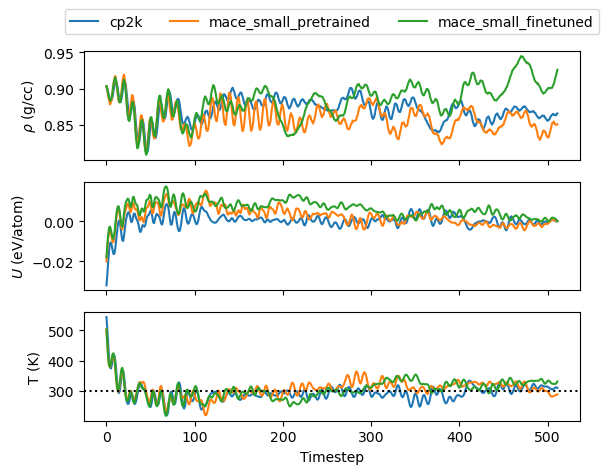

In [12]:
densities = {}
fig, axs = plt.subplots(3, 1, 
                        #figsize=(3.5, 4.1), 
                        sharex=True)
for name, trajectory in trajectories.items():
    print(name)
    density = [a.get_masses().sum() / a.get_volume() * units.m ** 3 / units.kg / 1000 for a in trajectory]
    densities[name] = np.asarray(density)
    axs[0].plot(density, label=name)
    axs[0].set_ylabel('$\\rho$ (g/cc)')
    
    axs[1].plot(
        [(a.get_potential_energy() - trajectory[-1].get_potential_energy()) / len(a) for a in trajectory],
        label=name,
    )
    axs[1].set_ylabel('$U$ (eV/atom)')
    
    axs[2].plot([a.get_temperature() for a in trajectory], label=name)
    axs[2].set_ylabel('T (K)')

    
axs[-1].set_xlabel('Timestep')
axs[2].axhline(298, color='k', linestyle='dotted', label='Target')
axs[0].legend(ncol=3, bbox_to_anchor=(0.5,1.45), loc='upper center')

In [13]:
{name: d[100:].mean() for name, d in densities.items()}

{'cp2k': 0.8723735727992793,
 'mace_small_pretrained': 0.8578908015840876,
 'mace_small_finetuned': 0.8883616250657872}

This is discouraging. It seems like the finetuning lead to an overfit to the 3 training trajectories and then divergence of the trajectory. The average is closer for the finetuned by coencidence, I think if we ran for longer it would diverge further. 

## Checking the uncertainty

In [14]:
traj_ft = trajectories['mace_small_finetuned']
calc_ft = calculators['mace_small_finetuned']
a0 = traj_ft[0]

In [15]:
a0.get_potential_energy()

-15217.7578125

In [16]:
calc_ft.get_potential_energy(a0)

-15217.7578125

In [17]:
calc_ft.calculate(a0)

In [18]:
calc_ft.get_property('energy_var')

4.4345855712890625e-05

In [22]:
calc.get_property('forces_comm').var(0).shape

(101, 3)

In [19]:
energy_var = []
forces_var = []
for i, frame in tqdm(enumerate(traj_ft), 
                     total=len(traj_ft), 
                     desc='computing uncertainties'): 
    calc_ft.calculate(frame)
    energy_var.append(calc.get_property('energy_var'))
    forces_var.append(calc.get_property('forces_comm').var(0).max())

computing uncertainties:  20%|█████████████████████████▎                                                                                                     | 102/512 [00:18<01:14,  5.51it/s]
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7ce0f42a91d0>>
Traceback (most recent call last):
  File "/home/mike/miniconda3/envs/cascade/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


KeyboardInterrupt: 

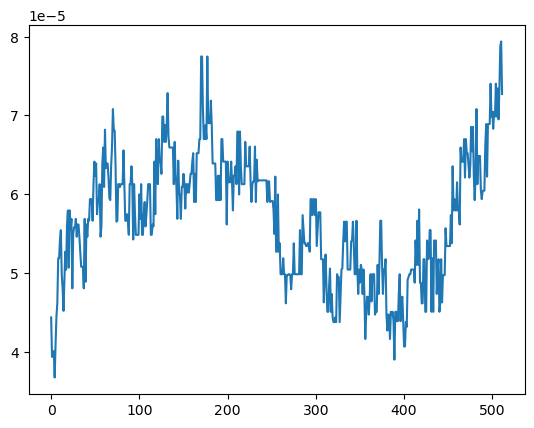

In [20]:
plt.plot(energy_var)

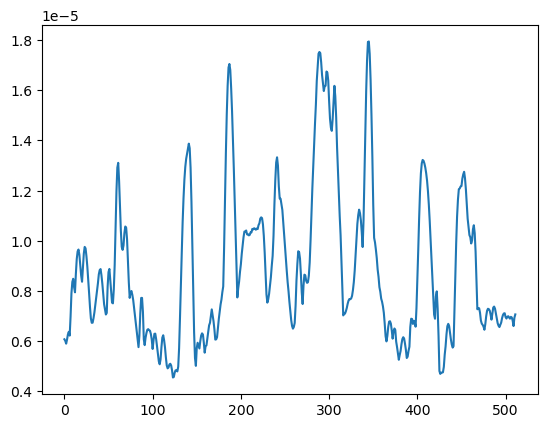

In [21]:
plt.plot(forces_var)

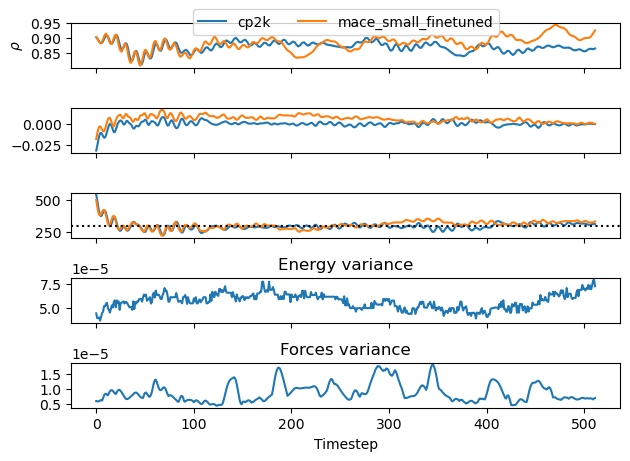

In [22]:
fig, axs = plt.subplots(5, sharex=True)
energies = {}
for name in ['cp2k', 'mace_small_finetuned']: 
    trajectory = trajectories[name]
    density = densities[name]
    PE = [(a.get_potential_energy() - trajectory[-1].get_potential_energy()) / len(a) for a in trajectory]
    T = [a.get_temperature() for a in trajectory]
    energies[name] = PE
    axs[0].plot(density, label=name)
    axs[0].set_ylabel('$\\rho$')
    axs[1].plot(PE, label=name)
    axs[2].plot(T, label=name)
axs[3].plot(energy_var)
axs[3].set_title('Energy variance')
axs[4].plot(forces_var)
axs[4].set_title('Forces variance')
axs[-1].set_xlabel('Timestep')
axs[2].axhline(298, color='k', linestyle='dotted', label='Target')
axs[0].legend(ncol=3, bbox_to_anchor=(0.5,1.45), loc='upper center')
plt.tight_layout()

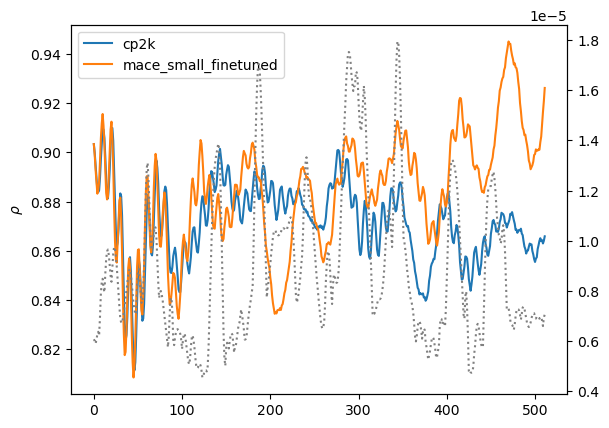

In [23]:
fig, axs = plt.subplots(1, sharex=True)
energies = {}
for name in ['cp2k', 'mace_small_finetuned']: 
    trajectory = trajectories[name]
    density = densities[name]
    PE = [(a.get_potential_energy() - trajectory[-1].get_potential_energy()) / len(a) for a in trajectory]
    T = [a.get_temperature() for a in trajectory]
    energies[name] = PE
    axs.plot(density, label=name)
    axs.set_ylabel('$\\rho$')
plt.legend()
ax2 = axs.twinx()
ax2.plot(forces_var, color='grey', linestyle='dotted')

In [24]:
energies

{'cp2k': [-0.03208865574256694,
  -0.02670536341584281,
  -0.02017686137624689,
  -0.014491240396033967,
  -0.01115242938614738,
  -0.01060679754455393,
  -0.012092493633672078,
  -0.014605786514858655,
  -0.016460466495046414,
  -0.016257201772280287,
  -0.013665296049499141,
  -0.00945160767327306,
  -0.004933733564354439,
  -0.0014139105742558085,
  0.0002951881188072557,
  -0.000370906049499921,
  -0.002895273336642024,
  -0.006784962742572269,
  -0.009632668712871993,
  -0.009892146138617415,
  -0.007061784940587771,
  -0.0031021441980123884,
  0.0004060771485221789,
  0.002378996148511553,
  0.0039470335049561905,
  0.0044769182178143714,
  0.0037733523762347766,
  0.0015639045940597407,
  -0.00037035011881034554,
  -0.0003643487425776611,
  0.001718362960403256,
  0.003705486613866789,
  0.0038338834356452054,
  0.002328553663366872,
  0.001055703643564046,
  0.00030371447523930777,
  -0.001017449821777311,
  -0.0033723759603919174,
  -0.005302395445547103,
  -0.0053267038613802

## I wonder how this compares to the training trajectories? 

In [25]:
reference_trajectories = list(sorted(glob('../0_setup/md/**/md.traj')))
reference_trajectories

['../0_setup/md/packmol-CH4-in-H2O=32-seed=0-blyp-npt=298/md.traj',
 '../0_setup/md/packmol-CH4-in-H2O=32-seed=1-blyp-npt=298/md.traj',
 '../0_setup/md/packmol-CH4-in-H2O=32-seed=2-blyp-npt=298/md.traj',
 '../0_setup/md/packmol-CH4-in-H2O=32-seed=3-blyp-npt=298/md.traj']

First run ML on the initial (training) geometries

In [26]:
initial_geometries = list(sorted(glob('../0_setup/final-geometries/*')))

In [27]:
initial_geometries

['../0_setup/final-geometries/packmol-CH4-in-H2O=32-seed=0-blyp.vasp',
 '../0_setup/final-geometries/packmol-CH4-in-H2O=32-seed=1-blyp.vasp',
 '../0_setup/final-geometries/packmol-CH4-in-H2O=32-seed=2-blyp.vasp',
 '../0_setup/final-geometries/packmol-CH4-in-H2O=32-seed=3-blyp.vasp']

In [28]:
for traj_file, initial_geometry in tqdm(zip(reference_trajectories[:-1], initial_geometries[:-1]),
                                            'geometries', total=3): 
    for name, calc in tqdm(calculators.items(), 'calculators'): 
        name = f'{Path(initial_geometry).name[:-5]}-npt={temperature}-calc={name}'
        run_dir = Path('md') / name
        run_dir.mkdir(exist_ok=True, parents=True)
        traj_file = run_dir / 'md.traj'
        atoms = read(reference_trajectory, index='0')
        start = 0
        atoms.calc = calc
        dyn = NPT(atoms,
          timestep=0.5 * units.fs,
          temperature_K=temperature,
          ttime=100 * units.fs,
          pfactor=0.01,
          externalstress=0,
          logfile=str(run_dir / 'md.log'),
          trajectory=str(traj_file),
          append_trajectory=False)
        dyn.run(512 - start)
        ml_traj_files.append((name, traj_file))

calculators:   0%|                                                                                                                                                       | 0/2 [00:00<?, ?it/s]WARNING: NPT: Setting the center-of-mass momentum to zero (was 0.00234261 -0.00646854 -0.00770384)

calculators:  50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 1/2 [00:24<00:24, 24.67s/it]WARNING: NPT: Setting the center-of-mass momentum to zero (was 0.00234261 -0.00646854 -0.00770384)

calculators:   0%|                                                                                                                                                       | 0/2 [00:00<?, ?it/s]WARNING: NPT: Setting the center-of-mass momentum to zero (was 0.00234261 -0.00646854 -0.00770384)

calculators:  50%|███████████████████████████████████████████████████████████████████████▌                                     

First just show the trajectories

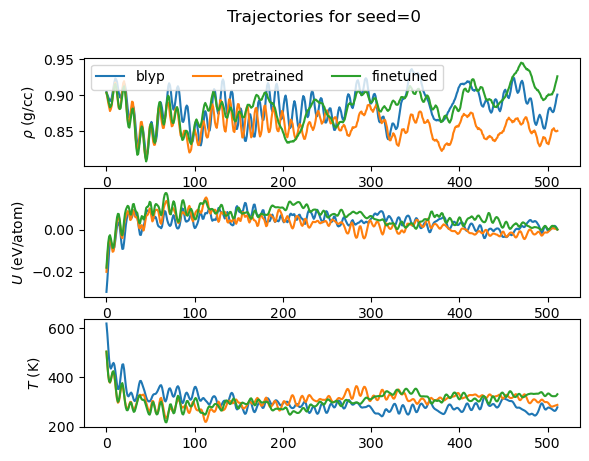

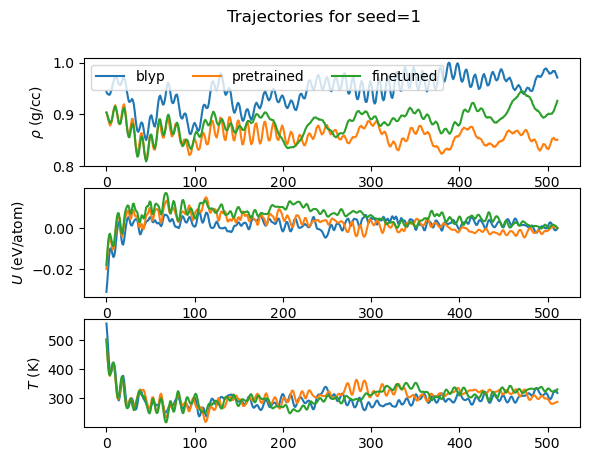

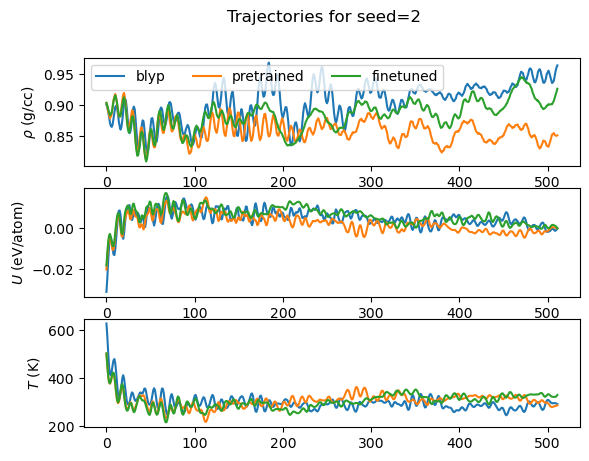

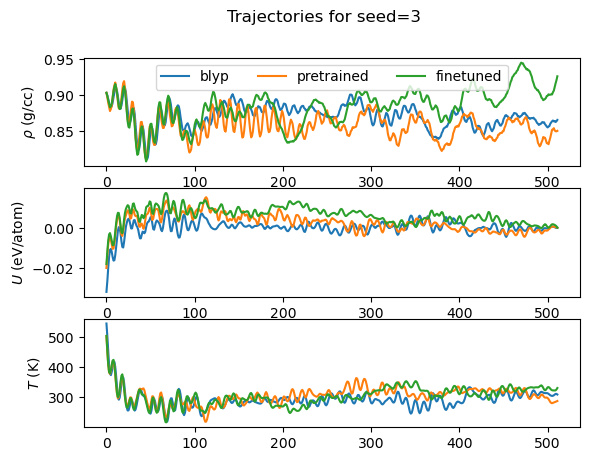

In [29]:
for seed in range(4): 
    fig, axs = plt.subplots(3)
    traj_ref = f'../0_setup/md/packmol-CH4-in-H2O=32-seed={seed}-blyp-npt=298/md.traj'
    traj_pt  = f'./md/packmol-CH4-in-H2O=32-seed={seed}-blyp-npt=298-calc=mace_small_pretrained/md.traj'
    traj_ft  = f'./md/packmol-CH4-in-H2O=32-seed={seed}-blyp-npt=298-calc=mace_small_finetuned/md.traj'
    traj_ref, traj_pt, traj_ft = map(lambda f: read(f, index=':'), [traj_ref, traj_pt, traj_ft])

    trajectories = [('blyp', traj_ref), ('pretrained', traj_pt), ('finetuned', traj_ft)]
    for name, trajectory in trajectories:
        density = [a.get_masses().sum() / a.get_volume() * units.m ** 3 / units.kg / 1000 for a in trajectory]
        energy  = [(a.get_potential_energy() - trajectory[-1].get_potential_energy()) / len(a) for a in trajectory]
        T = [a.get_temperature() for a in trajectory]
        axs[0].plot(density, label=name)
        axs[1].plot(energy, label=name)
        axs[2].plot(T, label=name)
    axs[0].set_ylabel('$\\rho$ (g/cc)')
    axs[1].set_ylabel('$U$ (eV/atom)')
    axs[2].set_ylabel('$T$ (K)')
    axs[0].legend(ncol=3)
    plt.suptitle(f'Trajectories for {seed=}')
    plt.show()

Then show the uncertainty

# Precompute the uncertainties

In [75]:
calc.get_property('forces_comm')

PropertyNotImplementedError: forces_comm property not implemented

In [74]:
#traj_uncertainties = {} # map {seed: {metric: traj}} 
for seed in range(4):
    #traj_uncertainties[seed] = defaultdict(lambda: list())
    for i, frame in tqdm(enumerate(traj_ft), 
                         total=len(traj_ft), 
                         desc='computing uncertainties'): 
        calc_ft.calculate(frame)
        forces_var = calc.get_property('forces_comm')#.var(0)
        #traj_uncertainties[seed]['force_var_max'].append(forces_var.max())
        #traj_uncertainties[seed]['force_var_mean'].append(forces_var.mean())
        #traj_uncertainties[seed]['energy_var'].append(calc.get_property('energy_var'))

computing uncertainties:   0%|                                                                                                                                         | 0/512 [00:00<?, ?it/s]


RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [72]:
forces_var

array([[7.05942330e-06, 2.81445546e-06, 6.24953316e-07],
       [3.45053508e-07, 7.77491209e-08, 2.17037055e-07],
       [1.67012914e-07, 1.43221575e-06, 1.01708849e-07],
       [1.02139715e-07, 3.37175585e-08, 3.05628532e-07],
       [3.33161012e-07, 7.20458104e-07, 1.67747615e-07],
       [6.28295425e-07, 2.19892428e-07, 6.49481649e-07],
       [3.30784871e-07, 2.90323783e-07, 3.22104313e-07],
       [6.15292151e-07, 8.84738256e-08, 7.10669923e-08],
       [4.77521212e-07, 3.28871408e-07, 1.32628401e-07],
       [1.88501303e-07, 2.57939519e-07, 6.71385294e-07],
       [3.07603216e-07, 4.17919438e-07, 5.62792138e-07],
       [8.95937660e-07, 3.82383796e-08, 1.88742683e-06],
       [2.99776730e-07, 5.81502242e-08, 2.29598839e-07],
       [3.23014319e-06, 4.72700719e-07, 4.04402243e-07],
       [8.36147507e-08, 3.55371355e-07, 2.90296526e-07],
       [9.79780737e-08, 6.53564598e-07, 3.82720202e-07],
       [4.10501784e-08, 4.33470682e-08, 6.09736333e-07],
       [1.74804541e-07, 6.63270

In [31]:
for seed, d in traj_uncertainties.items(): 
    for name, t in d.items():
        print(f'{seed}, {name}: {len(t)}')

0, force_var_max: 512
0, force_var_mean: 512
0, energy_var: 512
1, force_var_max: 512
1, force_var_mean: 512
1, energy_var: 512
2, force_var_max: 512
2, force_var_mean: 512
2, energy_var: 512
3, force_var_max: 512
3, force_var_mean: 512
3, energy_var: 512


Its possible that the system-wide UQ is masking some atomwise uncertainties, so we could see if a max over energy or forces. Really we should care more about the forces: is the model following the right dynamics, i.e. are the forces correct at a given point on the PES? energy itself is a meaningless number. TODO: try computing force uncertainties and look at mean/max UQ. See [this paper](https://pubs.rsc.org/en/content/articlelanding/2017/cp/c7cp00375g). Then compute the forces and see how accurate. 

Questions we can ask: 
1. how far have we gone off from the true path. This is hard to determine -- have to get the *exact* dynamical trjectory right. could be ways of estimating this. e.g. accumulate force uncertainties over time/propagate it to the current position. This is something we could control on. Try runing dynamics with each member -- measure UQ in positions at the end. Could this be a better UQ metric?  
2. is this structure a represenative of my ensmble -- is it appropriate given P/T?  Uncertain that we can do this have we violated the ficticious NPT conserved quantity/ If we were doing NVE dynamics, pull a structure check energy with DFT then we know it is bad. Is there somethign else we could do with NPT?

2 is cool, but 1 is perhaps more CS-ey. We can put a controller on this as well. 
Two variables that we're changing: variance total potential energy, max force variance, deviations over individual ensemble runs, are tehse any good at predicting actual wrongness of energy and forces at a given frame or amount of drift from the true path. Could use positions as the control vector. We care about the timings on the bond oscillations. Have we drifted more than (e.g.) three angstroms?  

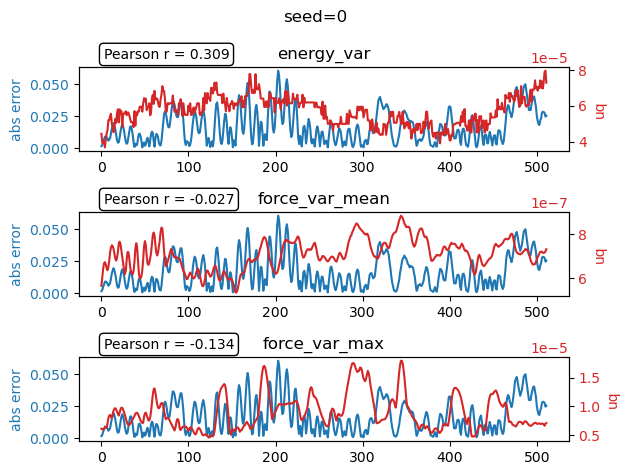

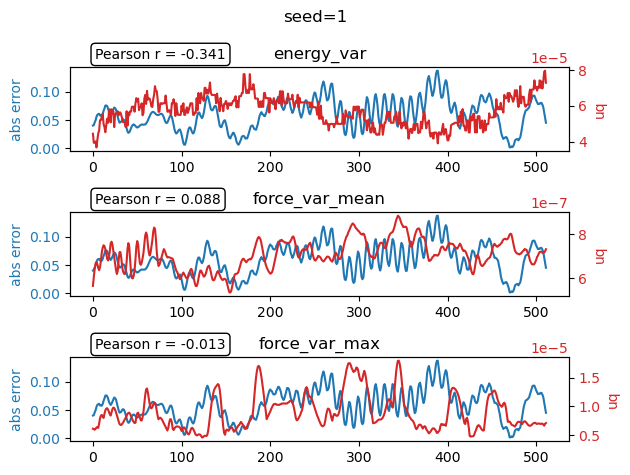

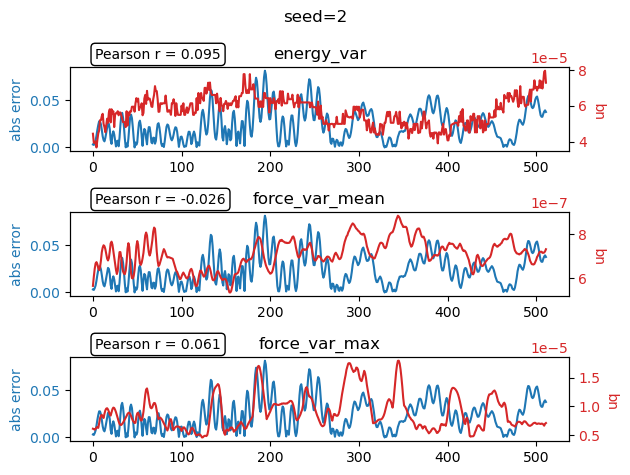

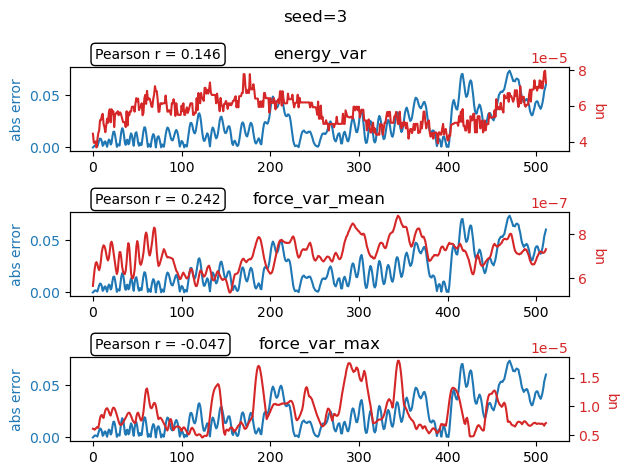

In [36]:
for seed in range(4): 
    fig, axs = plt.subplots(3)
    traj_ref = f'../0_setup/md/packmol-CH4-in-H2O=32-seed={seed}-blyp-npt=298/md.traj'
    traj_ft  = f'./md/packmol-CH4-in-H2O=32-seed={seed}-blyp-npt=298-calc=mace_small_finetuned/md.traj'
    traj_ref, traj_ft = map(lambda f: read(f, index=':'), [traj_ref, traj_ft])

    trajectories = [('blyp', traj_ref), ('finetuned', traj_ft)]
    energy, density = {}, {}
    for name, trajectory in trajectories:
        density[name] = [a.get_masses().sum() / a.get_volume() * units.m ** 3 / units.kg / 1000 for a in trajectory]
        energy[name]  = [(a.get_potential_energy() - trajectory[-1].get_potential_energy()) / len(a) for a in trajectory]
    
    uq = traj_uncertainties[seed]

    names = 'energy_var', 'force_var_mean', 'force_var_max'
    for i, name in enumerate(names): 
        err = np.asarray(density['blyp']) - np.asarray(density['finetuned'])
        err = np.abs(err)
        uq = traj_uncertainties[seed][name]
        
        ax = axs[i]
        color = 'tab:blue'
        ax.set_title(name)
        ax.set_ylabel(f'abs error', color=color)
        ax.plot(err, color=color)
        ax.tick_params(axis='y', labelcolor=color)

        color = 'tab:red'
        ax2 = ax.twinx()
        ax2.plot(uq, color=color)
        ax2.set_ylabel(f'uq', color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        
        t = ax.text(0.05, 1.1, 
                    f'Pearson r = {pearsonr(err, uq)[0]:0.3f}', 
                    transform=ax.transAxes)
        t.set_bbox(dict(boxstyle='round', facecolor='white'))
        
    
    plt.suptitle(f'{seed=}')
    plt.tight_layout()
    plt.show()

I'm not sure about anyt of these. the correlations are weak and I don't see much in the plots. Maybe instead of looking at the UQ as the trajetory runs we should do it block averages? Except we want this to be able to identify when a model is off. 

## Compute individual model trajectories

In [37]:
for traj_file, initial_geometry in tqdm(zip(reference_trajectories, initial_geometries),
                                            'geometries', total=4): 
    for model_ix in range(4):
        calc = MACECalculator(f'ensemble/model_{model_ix}.pt', device='cuda:0')
        name = f'{Path(initial_geometry).name[:-5]}-npt={temperature}-calc=mace_small_finetuned-ensemble_ix={model_ix}'
        print(name)
        run_dir = Path('md') / name
        run_dir.mkdir(exist_ok=True, parents=True)
        traj_file = run_dir / 'md.traj'
        atoms = read(reference_trajectory, index='0')
        start = 0
        atoms.calc = calc
        dyn = NPT(atoms,
          timestep=0.5 * units.fs,
          temperature_K=temperature,
          ttime=100 * units.fs,
          pfactor=0.01,
          externalstress=0,
          logfile=str(run_dir / 'md.log'),
          trajectory=str(traj_file),
          append_trajectory=False)
        dyn.run(512 - start)
        ml_traj_files.append((name, traj_file))

geometries:   0%|                                                                                                                                                        | 0/4 [00:00<?, ?it/s]WARNING: NPT: Setting the center-of-mass momentum to zero (was 0.00234261 -0.00646854 -0.00770384)


No dtype selected, switching to float32 to match model dtype.
packmol-CH4-in-H2O=32-seed=0-blyp-npt=298-calc=mace_small_finetuned-ensemble_ix=0


No dtype selected, switching to float32 to match model dtype.
packmol-CH4-in-H2O=32-seed=0-blyp-npt=298-calc=mace_small_finetuned-ensemble_ix=1


No dtype selected, switching to float32 to match model dtype.
packmol-CH4-in-H2O=32-seed=0-blyp-npt=298-calc=mace_small_finetuned-ensemble_ix=2


No dtype selected, switching to float32 to match model dtype.
packmol-CH4-in-H2O=32-seed=0-blyp-npt=298-calc=mace_small_finetuned-ensemble_ix=3


geometries:  25%|███████████████████████████████████▊                                                                                                           | 1/4 [01:41<05:04, 101.41s/it]WARNING: NPT: Setting the center-of-mass momentum to zero (was 0.00234261 -0.00646854 -0.00770384)


No dtype selected, switching to float32 to match model dtype.
packmol-CH4-in-H2O=32-seed=1-blyp-npt=298-calc=mace_small_finetuned-ensemble_ix=0


No dtype selected, switching to float32 to match model dtype.
packmol-CH4-in-H2O=32-seed=1-blyp-npt=298-calc=mace_small_finetuned-ensemble_ix=1


No dtype selected, switching to float32 to match model dtype.
packmol-CH4-in-H2O=32-seed=1-blyp-npt=298-calc=mace_small_finetuned-ensemble_ix=2


No dtype selected, switching to float32 to match model dtype.
packmol-CH4-in-H2O=32-seed=1-blyp-npt=298-calc=mace_small_finetuned-ensemble_ix=3


geometries:  50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 2/4 [03:24<03:24, 102.43s/it]WARNING: NPT: Setting the center-of-mass momentum to zero (was 0.00234261 -0.00646854 -0.00770384)


No dtype selected, switching to float32 to match model dtype.
packmol-CH4-in-H2O=32-seed=2-blyp-npt=298-calc=mace_small_finetuned-ensemble_ix=0


No dtype selected, switching to float32 to match model dtype.
packmol-CH4-in-H2O=32-seed=2-blyp-npt=298-calc=mace_small_finetuned-ensemble_ix=1


No dtype selected, switching to float32 to match model dtype.
packmol-CH4-in-H2O=32-seed=2-blyp-npt=298-calc=mace_small_finetuned-ensemble_ix=2


No dtype selected, switching to float32 to match model dtype.
packmol-CH4-in-H2O=32-seed=2-blyp-npt=298-calc=mace_small_finetuned-ensemble_ix=3


geometries:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 3/4 [05:08<01:42, 102.96s/it]WARNING: NPT: Setting the center-of-mass momentum to zero (was 0.00234261 -0.00646854 -0.00770384)


No dtype selected, switching to float32 to match model dtype.
packmol-CH4-in-H2O=32-seed=3-blyp-npt=298-calc=mace_small_finetuned-ensemble_ix=0


No dtype selected, switching to float32 to match model dtype.
packmol-CH4-in-H2O=32-seed=3-blyp-npt=298-calc=mace_small_finetuned-ensemble_ix=1


No dtype selected, switching to float32 to match model dtype.
packmol-CH4-in-H2O=32-seed=3-blyp-npt=298-calc=mace_small_finetuned-ensemble_ix=2


No dtype selected, switching to float32 to match model dtype.
packmol-CH4-in-H2O=32-seed=3-blyp-npt=298-calc=mace_small_finetuned-ensemble_ix=3


geometries: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [06:52<00:00, 103.02s/it]


In [ ]:
traj_file

## Compute memberwise uncertainty

The variance of the positions across over the four ensembel member trajectories

There is probably a nicer way to compute this but this will work for this small example

In [23]:
# iterate over all of the initial geometries
for traj_seed in range(4):
    # read the corresponding reference DFT-driven trajectory
    reference_traj =  f'../0_setup/md/packmol-CH4-in-H2O=32-seed={traj_seed}-blyp-npt=298/md.traj'
    reference_traj = read(reference_traj, index=':')
    
    # read in all of the ensemble member trajectories
    member_trajectories = []
    for member_seed in range(4):
        member_traj = f'md/packmol-CH4-in-H2O=32-seed={traj_seed}-blyp-npt=298-calc=mace_small_finetuned-ensemble_ix={member_seed}/md.traj'
        member_traj = read(member_traj, index=':')
        member_trajectories.append(np.asarray([atoms.positions for atoms in member_traj]))

    # this is an array of *positions* 
    # with shape: n_members, n_timesteps, n_atoms, 3 (spatial)
    member_trajectories = np.asarray(member_trajectories)
    
    # take variance along the n_members dimension
    # now has shape: n_timesteps, n_atoms, 3 (spatial)
    member_variance = member_trajectories.var(0)

    # take the mean along the n_atoms, 3 (spatial) dimensions
    member_variance = member_variance.mean((1,2))

    traj_uncertainties[traj_seed]['position_variance'] = member_variance

NameError: name 'traj_uncertainties' is not defined

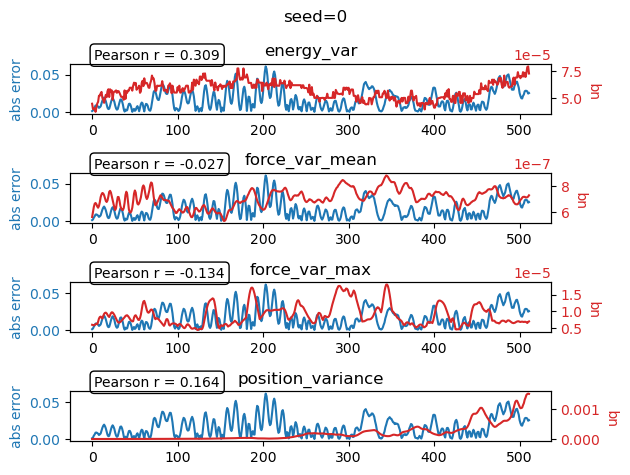

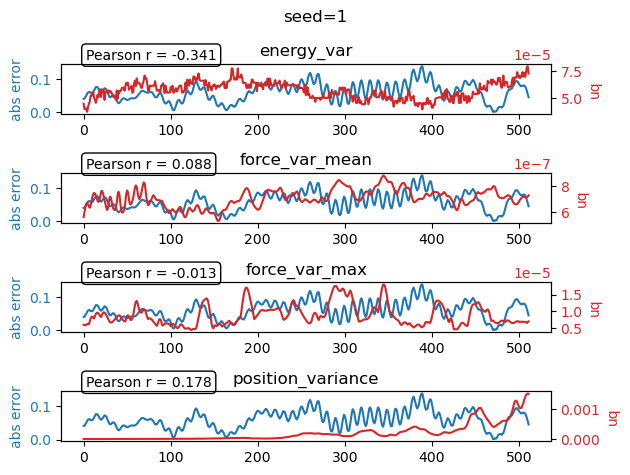

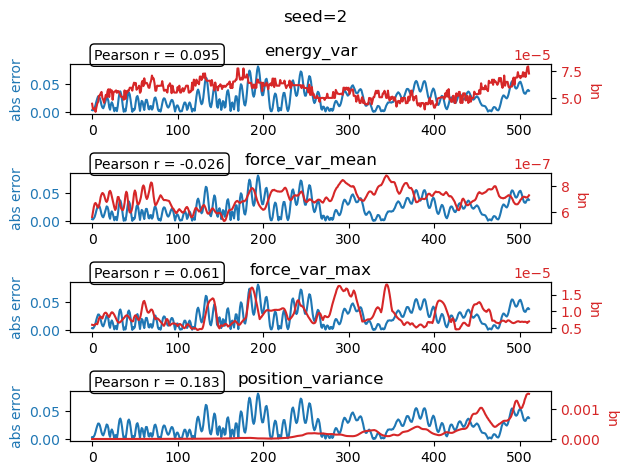

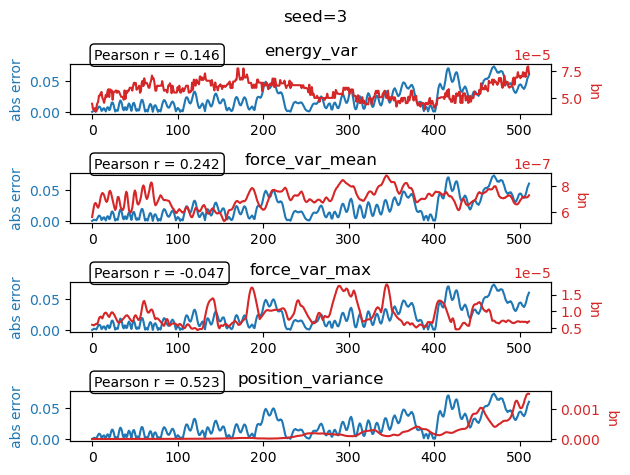

In [39]:
for seed in range(4): 
    fig, axs = plt.subplots(4)
    traj_ref = f'../0_setup/md/packmol-CH4-in-H2O=32-seed={seed}-blyp-npt=298/md.traj'
    traj_ft  = f'./md/packmol-CH4-in-H2O=32-seed={seed}-blyp-npt=298-calc=mace_small_finetuned/md.traj'
    traj_ref, traj_ft = map(lambda f: read(f, index=':'), [traj_ref, traj_ft])

    trajectories = [('blyp', traj_ref), ('finetuned', traj_ft)]
    energy, density = {}, {}
    for name, trajectory in trajectories:
        density[name] = [a.get_masses().sum() / a.get_volume() * units.m ** 3 / units.kg / 1000 for a in trajectory]
        energy[name]  = [(a.get_potential_energy() - trajectory[-1].get_potential_energy()) / len(a) for a in trajectory]
    
    uq = traj_uncertainties[seed]

    names = 'energy_var', 'force_var_mean', 'force_var_max', 'position_variance'
    for i, name in enumerate(names): 
        err = np.asarray(density['blyp']) - np.asarray(density['finetuned'])
        err = np.abs(err)
        uq = traj_uncertainties[seed][name]
        
        ax = axs[i]
        color = 'tab:blue'
        ax.set_title(name)
        ax.set_ylabel(f'abs error', color=color)
        ax.plot(err, color=color)
        ax.tick_params(axis='y', labelcolor=color)

        color = 'tab:red'
        ax2 = ax.twinx()
        ax2.plot(uq, color=color)
        #ax2.set_yscale('log')
        ax2.set_ylabel(f'uq', color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        
        t = ax.text(0.05, 1.1, 
                    f'Pearson r = {pearsonr(err, uq)[0]:0.3f}', 
                    transform=ax.transAxes)
        t.set_bbox(dict(boxstyle='round', facecolor='white'))
        
    
    plt.suptitle(f'{seed=}')
    plt.tight_layout()
    plt.show()

## TODO: plot the just the blyp and ensemble trajectory and then trajectory variance all on the same scale

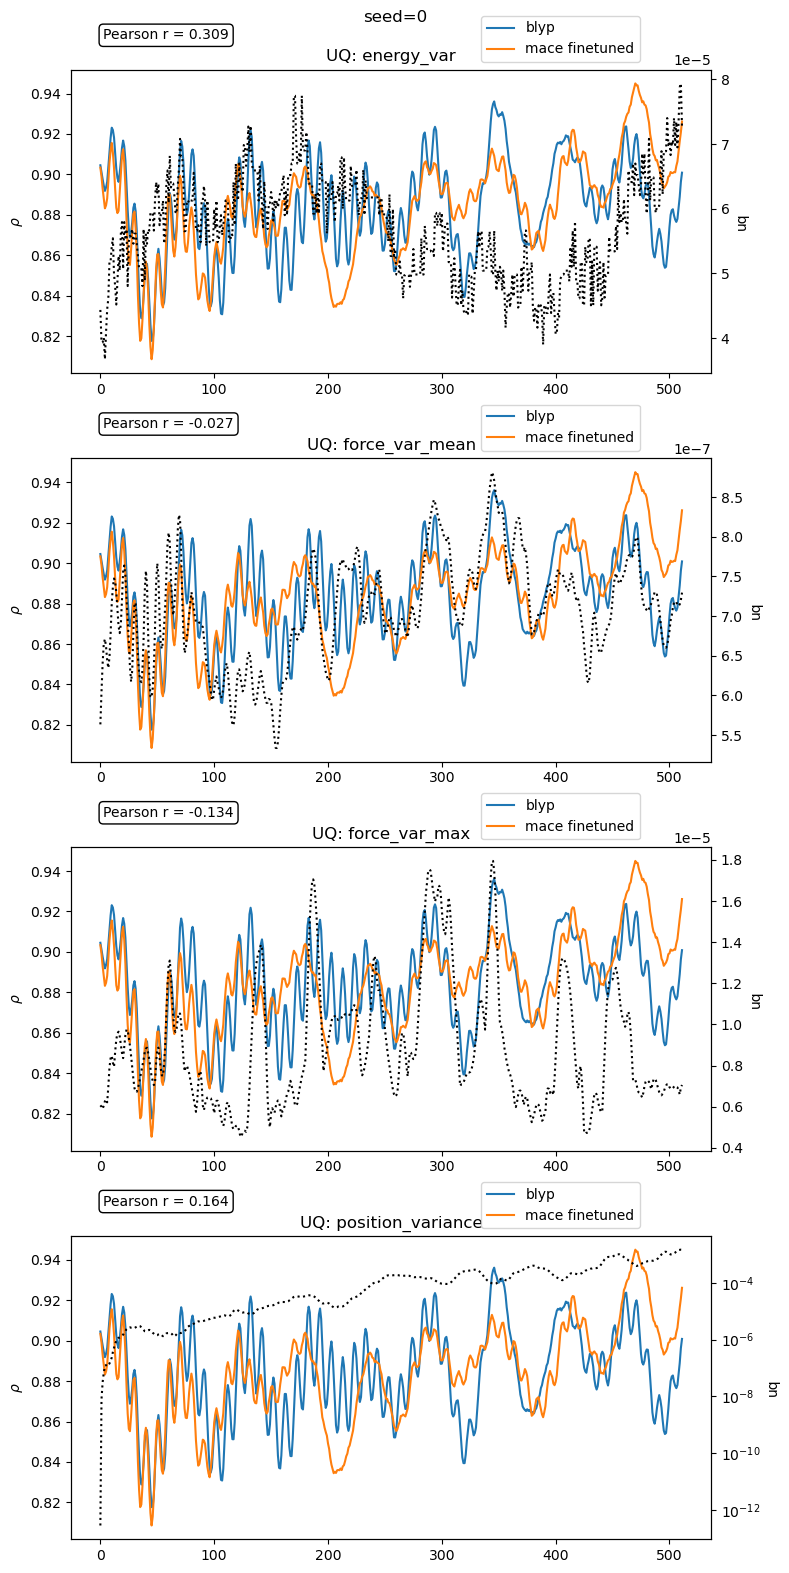

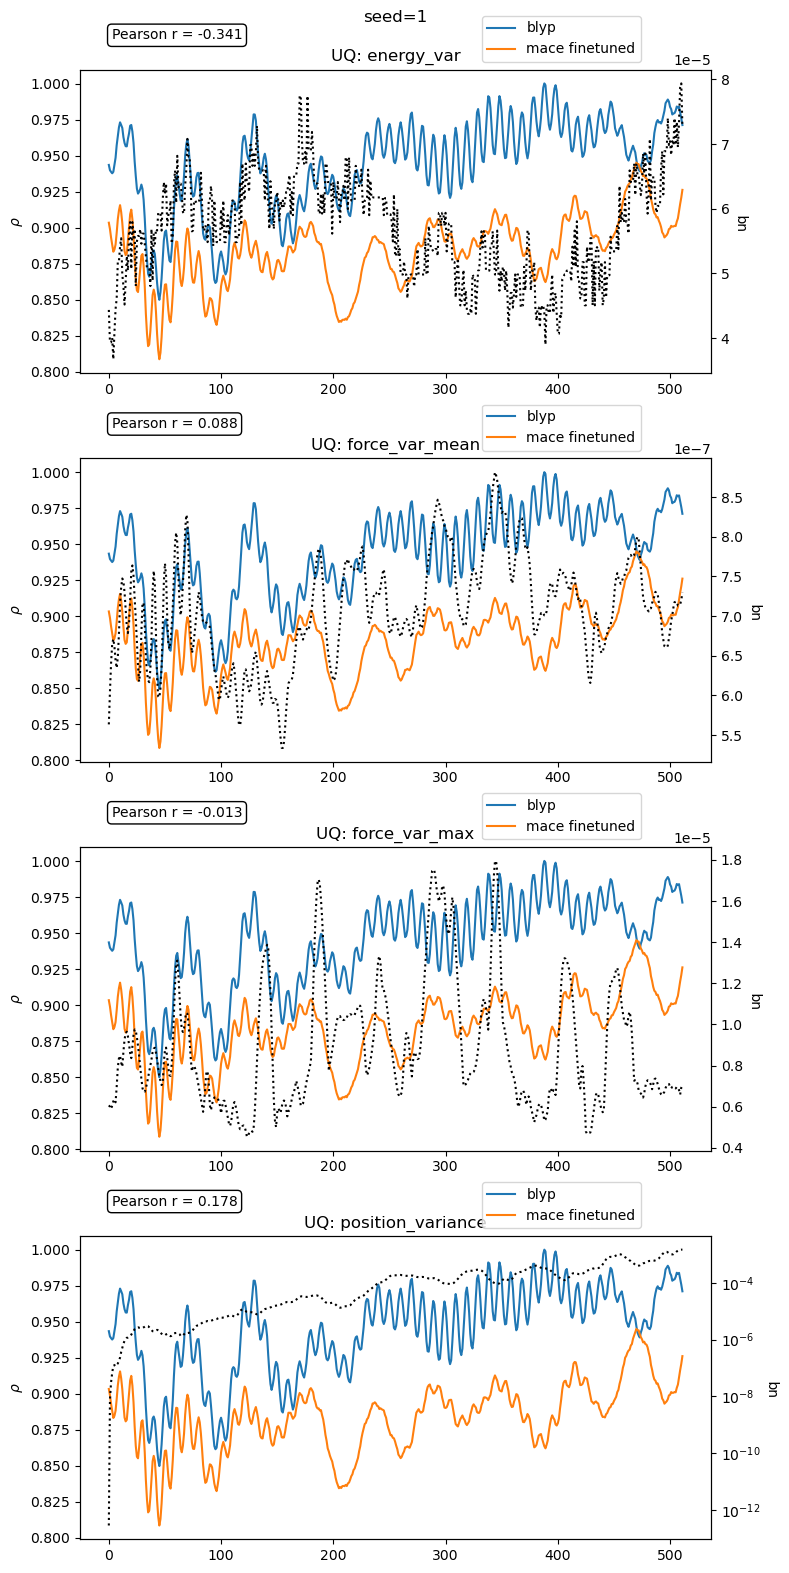

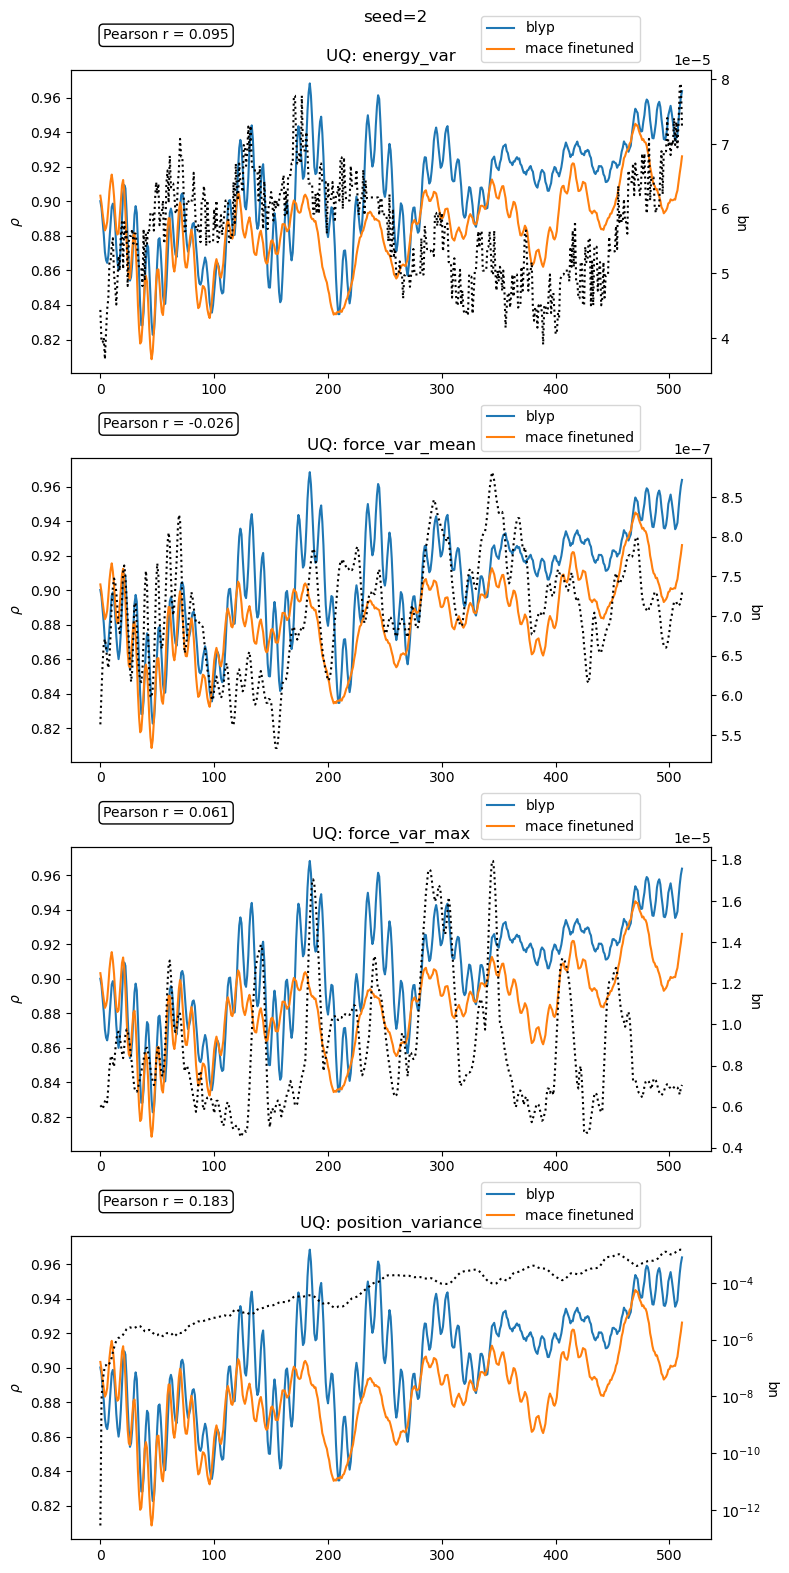

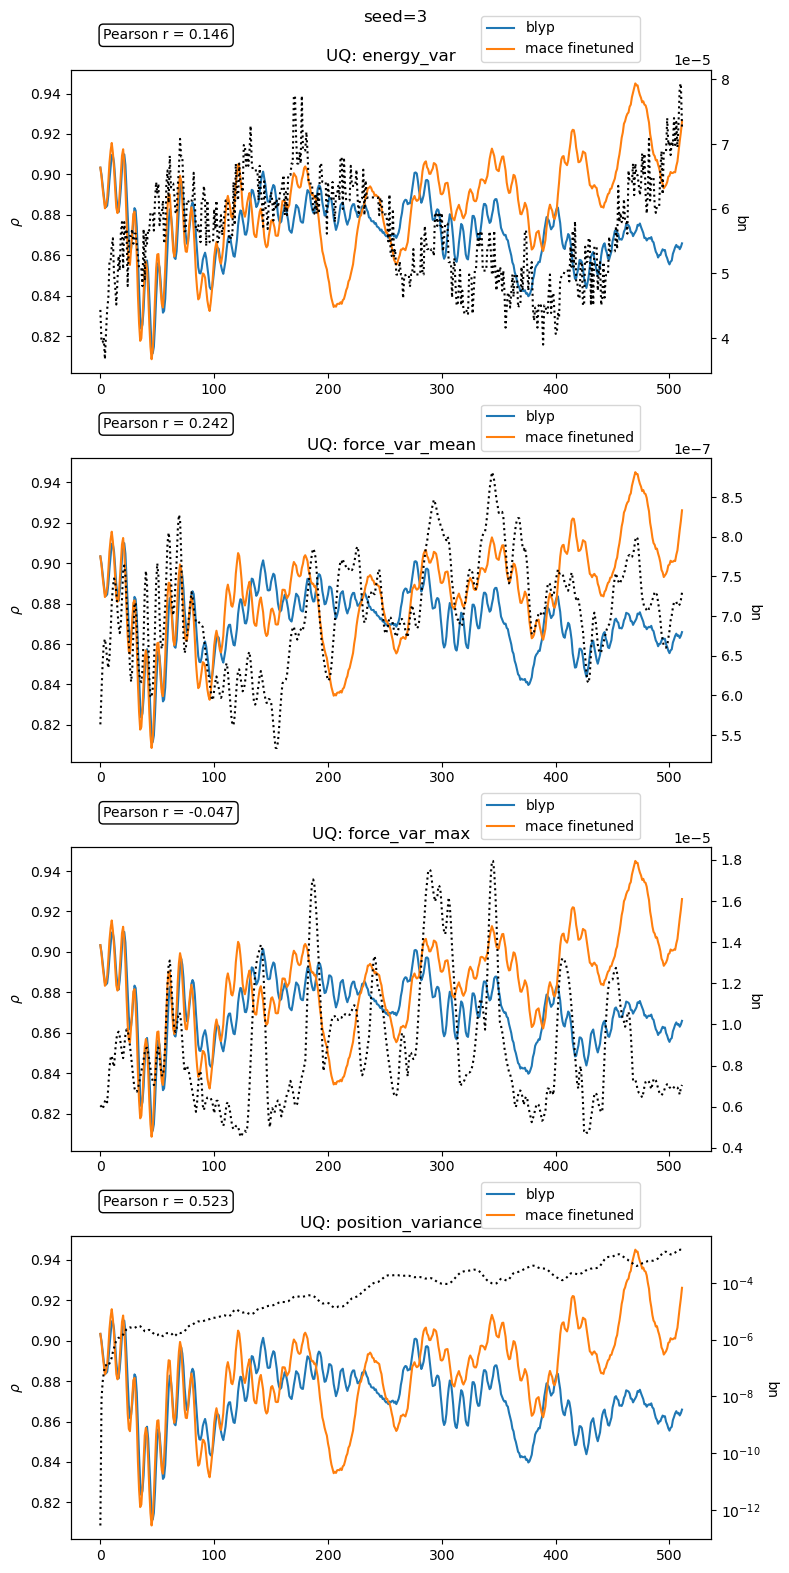

In [71]:
for seed in range(4): 
    names = ('energy_var', 
             'force_var_mean', 
             'force_var_max', 
             'position_variance',
             )

    n_metrics = len(names)
    fig, axs = plt.subplots(len(names), figsize=(8,4*n_metrics))
    if n_metrics == 1: 
        axs = [axs]
    traj_ref = f'../0_setup/md/packmol-CH4-in-H2O=32-seed={seed}-blyp-npt=298/md.traj'
    traj_ft  = f'./md/packmol-CH4-in-H2O=32-seed={seed}-blyp-npt=298-calc=mace_small_finetuned/md.traj'
    traj_ref, traj_ft = map(lambda f: read(f, index=':'), [traj_ref, traj_ft])

    trajectories = [('blyp', traj_ref), ('finetuned', traj_ft)]
    energy, density = {}, {}
    for name, trajectory in trajectories:
        density[name] = [a.get_masses().sum() / a.get_volume() * units.m ** 3 / units.kg / 1000 for a in trajectory]
        energy[name]  = [(a.get_potential_energy() - trajectory[-1].get_potential_energy()) / len(a) for a in trajectory]
    
    uq = traj_uncertainties[seed]


    for i, name in enumerate(names): 
        err = np.asarray(density['blyp']) - np.asarray(density['finetuned'])
        err = np.abs(err)
        uq = traj_uncertainties[seed][name]
        
        ax = axs[i]
        color = 'tab:blue'
        ax.set_title(f'UQ: {name}')
        ax.set_ylabel('$\\rho$')
        ax.plot(density['blyp'], label='blyp')
        ax.plot(density['finetuned'], label='mace finetuned')
        if True:#i == 0:
            ax.legend(bbox_to_anchor=(0.9, 1.2))
        #ax.tick_params(axis='y', labelcolor=color)

        color = 'black'
        ax2 = ax.twinx()
        ax2.plot(uq, color=color, linestyle='dotted')
        if name == 'position_variance': 
            ax2.set_yscale('log')
        ax2.set_ylabel(f'uq', color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        
        t = ax.text(0.05, 1.1, 
                    f'Pearson r = {pearsonr(err, uq)[0]:0.3f}', 
                    transform=ax.transAxes)
        t.set_bbox(dict(boxstyle='round', facecolor='white'))
        
    
    plt.suptitle(f'{seed=}')
    plt.tight_layout()
    plt.show()

Thoughts: 
* they all start to peak when things really start to go wrong in $\rho$, but they also peak at other times.
  - could think of this as false negative, but also possible that something else is going wrong besides the 
* RE the position variance:
  - the position variance has the highest correlation, but I think thats just because its increasing with time, as is error.
  - it does seem to have small jumps every time we "go off course", but is less of a pre-sign
 
- Its almost like doing a peak detection, except the peaks are a weak signal for the density really going off.
- Sometiems it kindof looks like if we lined up the trajectories at the peaks they would superimpose nicely until there was another peak and then they diverge for a while. As if the peaks separate regions of correct and incorrect dynamics.

Other questions: 
* is this model even fully trained?
* what if we tried the other model sizes?

Could we build toward multiple strategies: 
1. at all timesteps check do we trust the surrogate
2. choose how long we let it go instead of constantly revisiting
 - this is newer
 - greater opportunities for parallelism (longer tasks, less communication/context switching)

Want to be able to run all of the trajectories as long as we can go with least cost, assuring we have not drifted cumulatively a certain amount from the true path. 
approaches: 
1. turn on/off switching at each timestep
2. the fff/cascade way
    - let ML run for a fixed amount of time
    - after that time, audit
    - if audit fails: retrain ML and revert to last timestep, otherwise continue
3. Variant of 2 -- at some point decide to give up and rerun the dynamics with hifi
   - e.g. classical forcefields dont describe bond breaking. classical dynamics wont cut it.
   - achive scientific objective without having to first fully validate the potential
  
auditing strategy could be something like -- compute UQ over the whole trajectory snippet, and then do an audit on some of the worst frames. 

Cost based on auditing frequency: If I run too long I risk going off course, if I run too short I pay too much on audits. This is something we could put a controller on. To bait math people -- lets build a naive solution so that the problem is formalized enough for a nice formal solution. 

It could also be that we have the right density for the wrong reasons.
Two axes: 
1. UQ metric -- how much certainty shoudl I place in the simulator (as a function of time)
2. Other signals: force error -- take structure and run DFT to get forces. Or take DFT trajectory and run it with ML. Or partial RDF, O-O, C-O


Stuff mike can do while logan is gone:
1. The above <- implement #2 in a serial for loop
2. Get network training working on perlmutter

The argument is that the cascade way will spend the minimal amount of time computing stuff that we don't need to. There is probably a tradeoff and certain situations where this is the right strategy
